# Модели предсказания

[Датасет](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)

In [82]:
%matplotlib inline
import logging
from random import seed
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from prophet import Prophet
from sklearn.linear_model import ElasticNet
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_log_error,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, TargetEncoder
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

from lstm import HIDDEN_SIZE_FC, HIDDEN_SIZE_LSTM, SalesPredictorLSTM

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

seed(42)
sns.set_theme()

N_families = 10
N_stores = 10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cuda')

## Utilities

In [137]:
def plot_forecast(forecast, label="Forecast", family_idx=0, store_idx=0, split=None):
    global train, categories, store_nbrs
    family = categories[family_idx]
    store_nbr = store_nbrs[store_idx]
    if split is None:
        y_train_graph, y_test_graph, X_train_graph, X_test_graph = split_train_test(
            train, [family], [store_nbr]
        )
    else:
        y_train_graph, y_test_graph, X_train_graph, X_test_graph = split
    # Plot observed vs. predicted
    plt.figure(figsize=(12, 6))
    plt.plot(X_train_graph["date"], y_train_graph, label="Observed Train")
    plt.plot(X_test_graph["date"], y_test_graph, label="Observed Test")
    if forecast is not None:
        plt.plot(
            X_test_graph["date"],
            forecast[(family, store_nbr)],
            color="red",
            label=label,
        )
        plt.title(f"{label} vs. Observed")
    else:
        plt.title("Split")
    # Add vertical line to split train/forecast
    plt.axvline(
        x=X_train_graph["date"].iloc[-1], color="gray", linestyle=":", linewidth=2
    )
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid()
    plt.show()

### Загрузка обработанных данных

In [138]:
def load_data():
    train_raw = pd.read_csv(
        "./train.csv", parse_dates=["date"], index_col=0
    )
    return train_raw, None

In [139]:
def load_train():
    train_raw, _ = load_data()
    categories = pd.unique(train_raw["family"])
    store_nbrs = pd.unique(train_raw["store_nbr"])
    # clusters = pd.unique(train_raw["cluster"])
    train = train_raw.sort_values(by=["store_nbr", "family", "date"]).reset_index(
        drop=True
    )
    return categories, store_nbrs, train


categories, store_nbrs, train = load_train()
print(f"{categories=}")
print(f"{store_nbrs=}")
train.head()

categories=array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)
store_nbrs=array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])


,date,store_nbr,family,sales,cluster,is_holiday,oil_price
0,2013-01-02,1,AUTOMOTIVE,2.0,13,0,93.14
1,2013-01-03,1,AUTOMOTIVE,3.0,13,0,92.97
2,2013-01-04,1,AUTOMOTIVE,3.0,13,0,93.12
3,2013-01-07,1,AUTOMOTIVE,0.0,13,0,93.20
4,2013-01-08,1,AUTOMOTIVE,2.0,13,0,93.21


### Кодирование дат

In [140]:
def encode_dates(df, date_column):
    df = df.copy()

    dates = df[date_column]
    df["year"] = dates.dt.year - 2013
    df["day_of_year_sin"] = np.sin(2 * np.pi * dates.dt.dayofyear / 365)
    df["day_of_year_cos"] = np.cos(2 * np.pi * dates.dt.dayofyear / 365)
    df["day_of_month_sin"] = np.sin(2 * np.pi * dates.dt.day / 31)
    df["day_of_month_cos"] = np.cos(2 * np.pi * dates.dt.day / 31)
    df["day_of_week_sin"] = np.sin(2 * np.pi * dates.dt.dayofweek / 7)
    df["day_of_week_cos"] = np.cos(2 * np.pi * dates.dt.dayofweek / 7)
    df["month_sin"] = np.sin(2 * np.pi * dates.dt.month / 12)
    df["month_cos"] = np.cos(2 * np.pi * dates.dt.month / 12)
    new_cols = [
        "year",
        "day_of_year_sin",
        "day_of_year_cos",
        "day_of_month_sin",
        "day_of_month_cos",
        "day_of_week_sin",
        "day_of_week_cos",
        "month_sin",
        "month_cos",
    ]
    return df, new_cols


train, date_cols = encode_dates(train, "date")

### Нормализация числовых данных

In [141]:
def scale_data(df, cols):
    df = df.copy()
    scalers = {}
    for col in cols:
        scaler = MinMaxScaler()
        df[col] = scaler.fit_transform(df[[col]])
        scalers[col] = scaler
    return scalers, df


scaled_cols = ["sales", "oil_price"]
scalers, train = scale_data(train, scaled_cols)
train.head()

,date,store_nbr,family,sales,cluster,is_holiday,oil_price,year,day_of_year_sin,day_of_year_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,2013-01-02,1,AUTOMOTIVE,0.001103,13,0,0.792965,0,0.034422,0.999407,0.394356,0.918958,0.974928,-0.222521,0.5,0.866025
1,2013-01-03,1,AUTOMOTIVE,0.001654,13,0,0.790951,0,0.051620,0.998667,0.571268,0.820763,0.433884,-0.900969,0.5,0.866025
2,2013-01-04,1,AUTOMOTIVE,0.001654,13,0,0.792728,0,0.068802,0.997630,0.724793,0.688967,-0.433884,-0.900969,0.5,0.866025
3,2013-01-07,1,AUTOMOTIVE,0.000000,13,0,0.793675,0,0.120208,0.992749,0.988468,0.151428,0.000000,1.000000,0.5,0.866025
4,2013-01-08,1,AUTOMOTIVE,0.001103,13,0,0.793794,0,0.137279,0.990532,0.998717,-0.050649,0.781831,0.623490,0.5,0.866025


### Кодирование категориальных данных с помощью TargetEncoder

In [142]:
def encode_categorical(df, cols, target):
    df = df.copy()
    encoder = TargetEncoder(target_type="continuous")
    new_cols = [f"encoding_{col}" for col in cols]
    df[new_cols] = encoder.fit_transform(df[cols], df[target])
    return encoder, new_cols, df


cat_encoder, encoding_cols, train = encode_categorical(
    train, ["store_nbr", "family", "year"], "sales"
)
train.head()

,date,store_nbr,family,sales,cluster,is_holiday,oil_price,year,day_of_year_sin,day_of_year_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,encoding_store_nbr,encoding_family,encoding_year
0,2013-01-02,1,AUTOMOTIVE,0.001103,13,0,0.792965,0,0.034422,0.999407,0.394356,0.918958,0.974928,-0.222521,0.5,0.866025,0.070823,0.002897,0.058632
1,2013-01-03,1,AUTOMOTIVE,0.001654,13,0,0.790951,0,0.051620,0.998667,0.571268,0.820763,0.433884,-0.900969,0.5,0.866025,0.070489,0.002889,0.058768
2,2013-01-04,1,AUTOMOTIVE,0.001654,13,0,0.792728,0,0.068802,0.997630,0.724793,0.688967,-0.433884,-0.900969,0.5,0.866025,0.070489,0.002889,0.058768
3,2013-01-07,1,AUTOMOTIVE,0.000000,13,0,0.793675,0,0.120208,0.992749,0.988468,0.151428,0.000000,1.000000,0.5,0.866025,0.070920,0.002902,0.058836
4,2013-01-08,1,AUTOMOTIVE,0.001103,13,0,0.793794,0,0.137279,0.990532,0.998717,-0.050649,0.781831,0.623490,0.5,0.866025,0.070920,0.002902,0.058836


### Добавляем лаги соответсвенно анализу данных

In [143]:
def add_lags(df):
    df = df.copy()
    new_cols = ["lag_4", "lag_8", "lag_oil_14"]
    df["lag_4"] = df["sales"].shift(4)
    df["lag_8"] = df["sales"].shift(8)
    df["lag_oil_14"] = df["oil_price"].shift(14)
    return df.dropna(), new_cols


train, lag_cols = add_lags(train)
train.head()

,date,store_nbr,family,sales,cluster,is_holiday,oil_price,year,day_of_year_sin,day_of_year_cos,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,encoding_store_nbr,encoding_family,encoding_year,lag_4,lag_8,lag_oil_14
14,2013-01-23,1,AUTOMOTIVE,0.001654,13,0,0.815705,0,0.385663,0.922640,...,0.974928,-0.222521,0.5,0.866025,0.070920,0.002902,0.058836,0.000551,0.001103,0.792965
15,2013-01-24,1,AUTOMOTIVE,0.000000,13,0,0.819140,0,0.401488,0.915864,...,0.433884,-0.900969,0.5,0.866025,0.070920,0.002902,0.058836,0.000551,0.001654,0.790951
16,2013-01-25,1,AUTOMOTIVE,0.002756,13,0,0.816771,0,0.417194,0.908818,...,-0.433884,-0.900969,0.5,0.866025,0.070489,0.002889,0.058768,0.000000,0.001103,0.792728
17,2013-01-28,1,AUTOMOTIVE,0.001654,13,0,0.826247,0,0.463550,0.886071,...,0.000000,1.000000,0.5,0.866025,0.070839,0.002903,0.059030,0.000551,0.000551,0.793675
18,2013-01-29,1,AUTOMOTIVE,0.001103,13,0,0.846026,0,0.478734,0.877960,...,0.781831,0.623490,0.5,0.866025,0.070489,0.002889,0.058768,0.001654,0.000551,0.793794


### Разбиваем на train, test

In [144]:
def split_train_test(df, categories, store_nbrs, train_size=0.8, target_col="sales"):
    # Filter relevant data first to reduce processing
    filtered = df[
        df["family"].isin(categories) & df["store_nbr"].isin(store_nbrs)
    ].copy()
    # Sort by date to maintain temporal order
    filtered = filtered.sort_values(["family", "store_nbr", "date"]).reset_index(
        drop=True
    )

    # Pre-allocate lists for collecting splits
    X_train_list, X_test_list = [], []
    y_train_list, y_test_list = [], []

    for category in categories:
        for store_nbr in store_nbrs:
            # Filter for specific category-store combination
            subset = filtered[
                (filtered["family"] == category) & (filtered["store_nbr"] == store_nbr)
            ]

            if len(subset) == 0:
                continue

            # Calculate split index
            split_idx = int(len(subset) * train_size)

            # Split into train/test
            train_sub = subset.iloc[:split_idx]
            test_sub = subset.iloc[split_idx:]

            # Split into X and y while preserving index
            y_train_list.append(train_sub[target_col])
            y_test_list.append(test_sub[target_col])
            X_train_list.append(train_sub.drop(columns=target_col))
            X_test_list.append(test_sub.drop(columns=target_col))

    # Concatenate all parts
    X_train = pd.concat(X_train_list)
    X_test = pd.concat(X_test_list)
    y_train = pd.concat(y_train_list)
    y_test = pd.concat(y_test_list)

    return y_train, y_test, X_train, X_test


# Usage
y_train, y_test, X_train, X_test = split_train_test(
    train, categories[:N_families], store_nbrs[:N_stores]
)
X_test[lag_cols] = 0.0

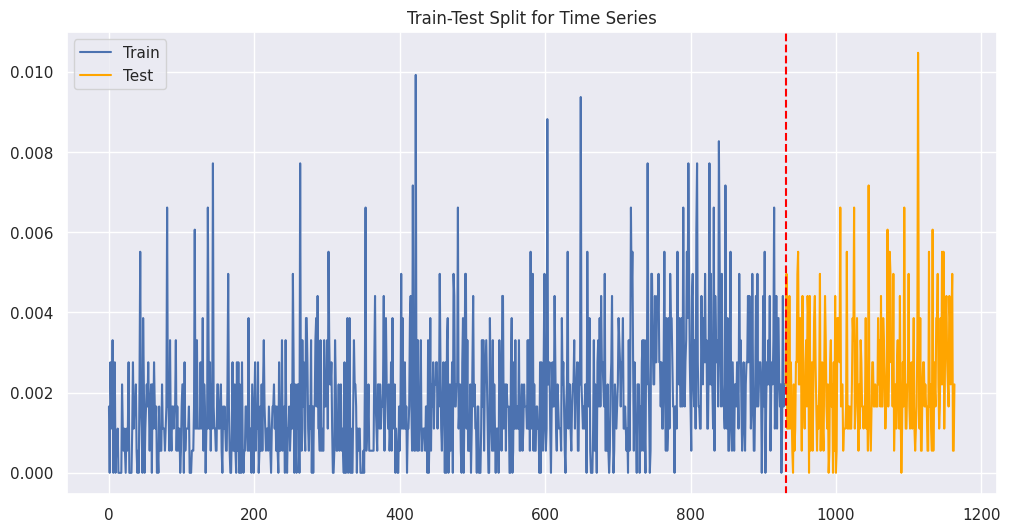

In [145]:
y_train_graph, y_test_graph, _, _ = split_train_test(
    train, [categories[0]], [store_nbrs[0]]
)
plt.figure(figsize=(12, 6))
plt.plot(y_train_graph.index, y_train_graph, label="Train")
plt.plot(y_test_graph.index, y_test_graph, label="Test", color="orange")
plt.axvline(x=y_test_graph.index[0], color="red", linestyle="--")
plt.legend()
plt.title("Train-Test Split for Time Series")
plt.show()

In [146]:
# train.to_csv("./data/processed/features.csv", index=False)

## Расчет метрик для модели

In [93]:
def metrics(y_test, y_pred, verbose=False):
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmsle = root_mean_squared_log_error(y_test, y_pred)
    if verbose:
        print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, RMSLE: {rmsle:.4f}")
    return mae, rmse, rmsle

def test_forecast(forecast, categories, store_nbrs, to_numpy=True):
    global X_test, y_test, scalers
    rmsles = []
    y_val = y_test.copy()
    y_val["sales"] = scalers["sales"].inverse_transform(
        y_test.to_numpy().reshape(-1, 1)
    )
    for category in categories:
        for store_nbr in store_nbrs:
            mask = (X_test["family"] == category) & (X_test["store_nbr"] == store_nbr)
            yhat = forecast[(category, store_nbr)]
            yhat_scaled = (
                scalers["sales"]
                .inverse_transform(yhat.to_numpy().reshape(-1, 1) if to_numpy else yhat.reshape(-1, 1))
                .clip(0.001)
            )
            _, _, rmsle = metrics(y_val[X_test[mask].index], yhat_scaled)
            rmsles.append(rmsle)
    mean = np.mean(rmsles)
    print(f"Mean rmsle is {mean:.4f}")
    return forecast, mean

def test_model(model, categories, store_nbrs, X_train=X_train):
    global X_test, y_test, scalers
    forecast = model.forecast(X_train, X_test)
    return forecast, test_forecast(forecast, categories, store_nbrs)

## Подбор моделей

In [94]:
class Model:
    def __init__(self, categories, store_nbrs):
        self.categories = categories
        self.store_nbrs = store_nbrs
        self.transform_pred = lambda x: x

    def fit(self, X, y):
        raise NotImplementedError

    def _forecast_ts(self, X_train, X_test):
        ts = pd.concat([X_train, X_test])
        ts.loc[X_test.index, "sales"] = 0.0
        for idx in X_test.index:
            features = ts.loc[idx].T.drop(["sales"])
            # generate lags
            for lag in self.lags:
                features[f"lag_{lag}"] = ts["sales"].shift(lag).loc[idx]
            for lag in self.oil_lags:
                features[f"lag_oil_{lag}"] = ts["oil_price"].shift(lag).loc[idx]

            pred = self.transform_pred(
                self.model.predict([features]).clip(0, 100000)[0]
            )
            ts.loc[idx, "sales"] = pred
        forecast = ts.loc[X_test.index, "sales"].to_frame()
        return forecast

    def forecast(self, X_train, X_test):
        forecasts = {}
        for family in self.categories:
            for store_nbr in self.store_nbrs:
                train = X_train[
                    (X_train["family"] == family) & (X_train["store_nbr"] == store_nbr)
                ].drop(columns=["family", "store_nbr", "date"])
                test = X_test[
                    (X_test["family"] == family) & (X_test["store_nbr"] == store_nbr)
                ].drop(columns=["family", "store_nbr", "date"])
                forecast = self._forecast_ts(train, test)
                forecasts[(family, store_nbr)] = forecast
        return forecasts


### 1 модель (Prophet)

In [95]:
class ProphetModel:
    def __init__(self, categories, store_nbrs):
        self.categories = categories
        self.store_nbrs = store_nbrs
        self.models = {}

    def _get_model(self):
        prophet = Prophet(
            yearly_seasonality=True,  # Auto-detects yearly seasonality
            weekly_seasonality=False,  # Disable weekly
            daily_seasonality=False,  # Disable daily
        )
        prophet.add_seasonality(name="4_day", period=4, fourier_order=3)
        prophet.add_regressor("oil_price")
        return prophet

    def fit(self, X, y):
        df = pd.DataFrame(y).rename({"sales": "y"}, axis=1).copy()
        df["oil_price"] = X["oil_price"]
        df["family"] = X["family"]
        df["store_nbr"] = X["store_nbr"]
        df["ds"] = X["date"]

        for category in self.categories:
            for store_nbr in self.store_nbrs:
                model = self._get_model()
                model.fit(
                    df[(df["family"] == category) & (df["store_nbr"] == store_nbr)]
                )
                self.models[(category, store_nbr)] = model

    def forecast(self, X_train, X_test, return_train=False):
        forecast = {}
        for category in self.categories:
            for store_nbr in self.store_nbrs:
                model = self.models.get((category, store_nbr))
                if not model:
                    continue

                train_mask = (X_train["family"] == category) & (
                    X_train["store_nbr"] == store_nbr
                )
                test_mask = (X_test["family"] == category) & (
                    X_test["store_nbr"] == store_nbr
                )

                X_train_loop = X_train[train_mask]
                X_test_loop = X_test[test_mask]

                if len(X_test_loop) == 0:
                    continue
                future = pd.DataFrame(
                    {
                        "ds": pd.concat(
                            [X_train_loop["date"], X_test_loop["date"]]
                        ).values
                    }
                )
                future["oil_price"] = pd.concat(
                    [X_train_loop["oil_price"], X_test_loop["oil_price"]]
                ).values
                if return_train:
                    forecast[(category, store_nbr)] = model.predict(future)["yhat"]
                else:
                    forecast[(category, store_nbr)] = model.predict(future)\
                        ["yhat"][-len(X_test_loop):]
        return forecast

In [96]:
prophet = ProphetModel(categories[:N_families], store_nbrs[:N_stores])
prophet.fit(X_train, y_train)

Mean rmsle is 3.2503


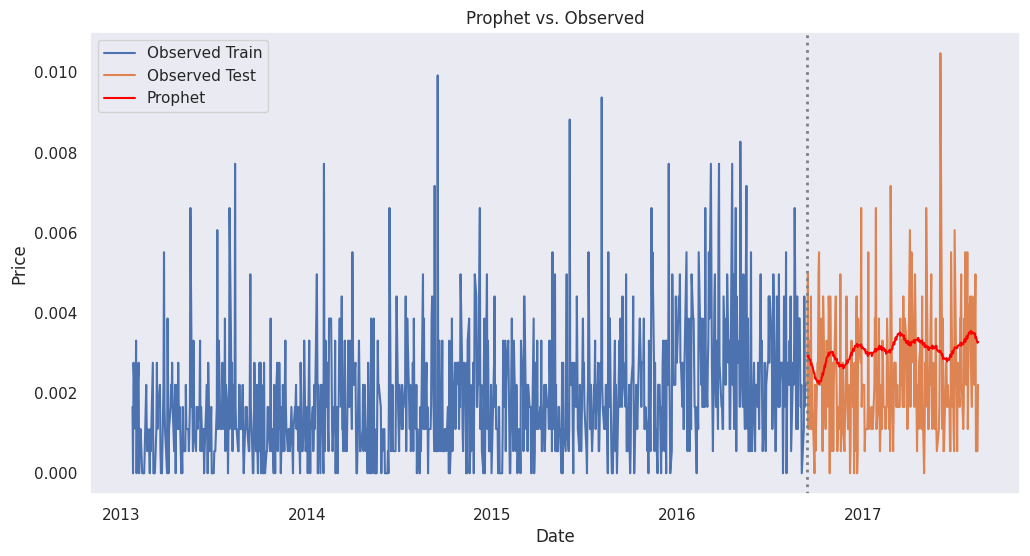

In [97]:
true_prophet_forecast, _ = test_model(prophet, categories[:N_families], store_nbrs[:N_stores])
plot_forecast(true_prophet_forecast, label="Prophet")

### 2 модель (ElasticNet)

In [98]:
class ElasticNetModel(Model):
    def __init__(self, categories, store_nbrs):
        super().__init__(categories, store_nbrs)
        self.lags = [4, 8]
        self.oil_lags = [14]
        self.model = Pipeline(
            steps=[
                ("prepocesser", PolynomialFeatures(degree=3, include_bias=False)),
                (
                    "estimator",
                    ElasticNet(
                        alpha=0.7,
                        positive=True,
                        random_state=42,
                    ),
                ),
            ]
        )

    def fit(self, X, y):
        y = y.shift(-1).dropna().copy()
        X = X[:-1].drop(["family", "store_nbr", "date"], axis=1).copy().values
        self.model.fit(X, y)

In [99]:
enet = ElasticNetModel(categories[:N_families], store_nbrs[:N_stores])
enet.fit(X_train, y_train)

Mean rmsle is 5.6347


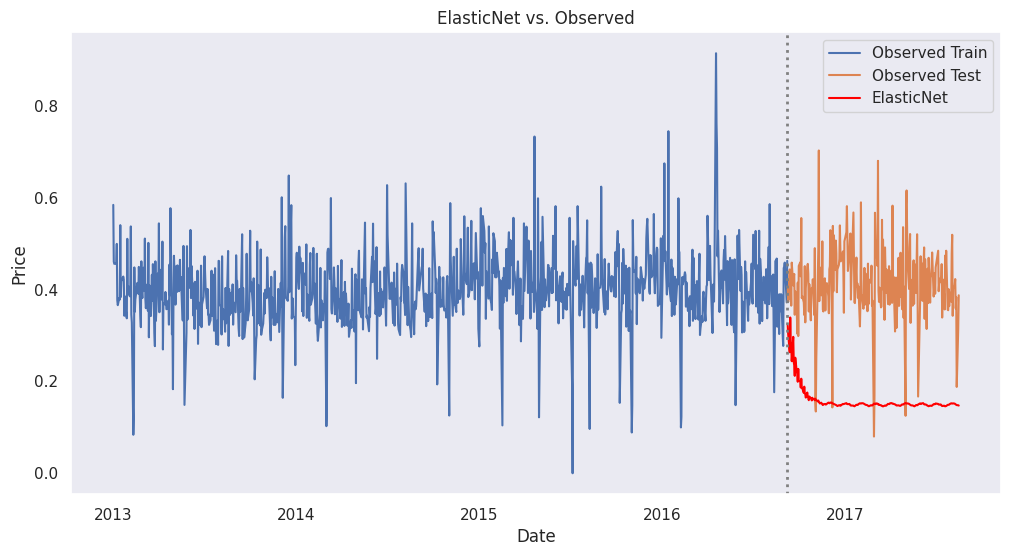

In [100]:
X_forecast = X_train.copy()
X_forecast["sales"] = y_train
forecast, _ = test_model(enet, enet.categories, enet.store_nbrs, X_forecast)
plot_forecast(forecast, label="ElasticNet", family_idx=7, store_idx=0)

### 3 модель (XGBoost)

In [101]:
class XGBoostModel(Model):
    def __init__(self, categories, store_nbrs):
        super().__init__(categories, store_nbrs)
        self.lags = [4, 8]
        self.oil_lags = [14]
        self.transofrm_pred = np.expm1
        self.model = XGBRegressor(
            n_estimators=2 * len(categories) * len(store_nbrs),
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="reg:squarederror",
            random_state=42,
        )

    def fit(self, X, y):
        y = y.shift(-1).dropna().copy()
        y_transformed = np.log1p(y)
        X = X[:-1].drop(["family", "store_nbr", "date"], axis=1).copy()
        self.model.fit(X, y_transformed)


In [102]:
xgb = XGBoostModel(categories[:N_families], store_nbrs[:N_stores])
xgb.fit(X_train, y_train)

Mean rmsle is 3.4374


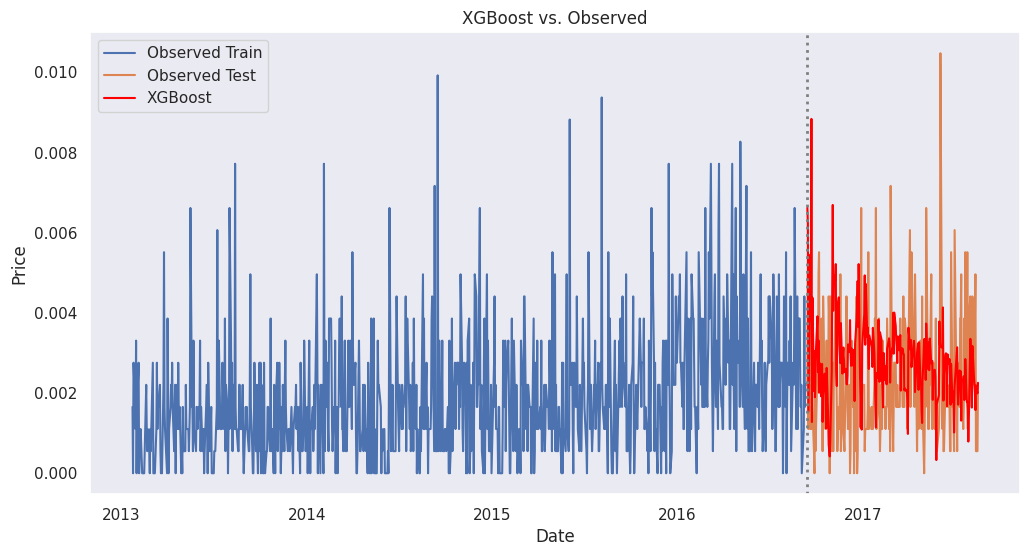

In [103]:
X_forecast = X_train.copy()
X_forecast["sales"] = y_train
forecast, _ = test_model(xgb, xgb.categories, xgb.store_nbrs, X_forecast)
plot_forecast(forecast, label="XGBoost")

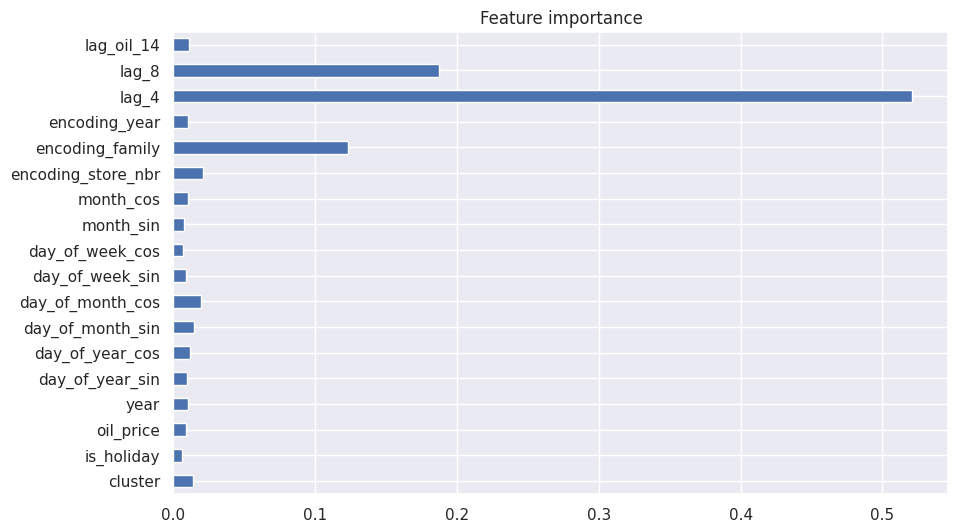

In [104]:
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(
    xgb.model.feature_importances_,
    index=X_train.drop(["family", "store_nbr", "date"], axis=1).columns,
)
feat_importances.plot(kind="barh")
plt.title("Feature importance")
plt.show()

### 4 модель LSTM

#### Utils

In [126]:
df = train[
    train["family"].isin(categories[:N_families])
    & train["store_nbr"].isin(store_nbrs[:N_stores])
].copy()

In [127]:
target_col = "sales"
static_cat_cols = ["encoding_family", "encoding_store_nbr"]
dynamic_num_cols = [
    "sales",
    "oil_price",
    "is_holiday",
    "encoding_year",
    "day_of_year_sin",
    "day_of_year_cos",
    "day_of_month_sin",
    "day_of_month_cos",
    "day_of_week_sin",
    "day_of_week_cos",
    "month_sin",
    "month_cos",
]


In [128]:
SEQUENCE_LENGTH = 4


def create_sequences(
    data,
    seq_length=SEQUENCE_LENGTH,
    dynamic_cols=dynamic_num_cols,
    static_cols=static_cat_cols,
    target_col="sales",
):
    sequences = []
    targets = []
    static_features_for_target = []

    entity_cols = ["family", "store_nbr"]  # Core entity identifiers

    for _, group in tqdm(data.groupby(entity_cols)):
        group_dynamic_data = group[dynamic_cols].values
        group_static_data_at_target = group[
            static_cols + [target_col]
        ].values  # Static features + target sales

        for i in range(len(group) - seq_length):
            seq = group_dynamic_data[i : i + seq_length]
            sequences.append(seq)

            target_val = group_static_data_at_target[
                i + seq_length, -1
            ]
            targets.append(target_val)

            static_vals = group_static_data_at_target[i + seq_length, :-1]
            static_features_for_target.append(static_vals)

    return (
        np.array(sequences),
        np.array(static_features_for_target),
        np.array(targets).reshape(-1, 1),
    )


In [129]:
X_dynamic, X_static, y = create_sequences(df, SEQUENCE_LENGTH)

print(f"X_dynamic shape: {X_dynamic.shape}")
print(f"X_static shape: {X_static.shape}")
print(f"y shape: {y.shape}")

  0%|          | 0/100 [00:00<?, ?it/s]

X_dynamic shape: (117386, 4, 12)
X_static shape: (117386, 2)
y shape: (117386, 1)


In [130]:
(X_dynamic_train, X_dynamic_val, X_static_train, X_static_val, y_train, y_val) = (
    train_test_split(X_dynamic, X_static, y, test_size=0.2, random_state=42)
)

In [131]:
BATCH_SIZE = 64


class SalesDataset(Dataset):
    def __init__(self, dynamic_features, static_features, targets):
        self.dynamic_features = torch.tensor(dynamic_features, dtype=torch.float32)
        self.static_features = torch.tensor(static_features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return (
            self.dynamic_features[idx],
            self.static_features[idx],
            self.targets[idx],
        )


train_dataset = SalesDataset(X_dynamic_train, X_static_train, y_train)
val_dataset = SalesDataset(X_dynamic_val, X_static_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


#### Model

In [132]:
model = SalesPredictorLSTM(
    num_dynamic_features=12,
    lstm_hidden_size=HIDDEN_SIZE_LSTM,
    fc_hidden_size=HIDDEN_SIZE_FC,
    num_static_features=2,
)
# model.load_state_dict(torch.load("./models/lstm_sales.pth"))
model.to(DEVICE)
model.eval()

SalesPredictorLSTM(
  (static_mlp): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
  )
  (lstm): LSTM(12, 64, batch_first=True)
  (fc1): Linear(in_features=80, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [133]:
EPOCHS = 10
LEARNING_RATE = 5e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nStarting Training...")
for epoch in range(EPOCHS):
    model.train()
    train_loss_epoch = 0
    for dynamic_batch, static_batch, target_batch in tqdm(train_loader):
        dynamic_batch, static_batch, target_batch = (
            dynamic_batch.to(DEVICE),
            static_batch.to(DEVICE),
            target_batch.to(DEVICE),
        )

        optimizer.zero_grad()
        outputs = model(dynamic_batch, static_batch)
        loss = criterion(outputs, target_batch)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()

    train_loss_epoch /= len(train_loader)

    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for dynamic_batch, static_batch, target_batch in tqdm(val_loader):
            dynamic_batch, static_batch, target_batch = (
                dynamic_batch.to(DEVICE),
                static_batch.to(DEVICE),
                target_batch.to(DEVICE),
            )
            outputs = model(dynamic_batch, static_batch)
            loss = criterion(outputs, target_batch)
            val_loss_epoch += loss.item()
    val_loss_epoch /= len(val_loader)

    print(
        f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss_epoch:.6f}, Val Loss: {val_loss_epoch:.6f}"
    )



Starting Training...


  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.058556, Val Loss: 0.059574


  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.058582, Val Loss: 0.059574


  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.058554, Val Loss: 0.059574


  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.058572, Val Loss: 0.059574


  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.058584, Val Loss: 0.059574


  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.058573, Val Loss: 0.059574


  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.058569, Val Loss: 0.059574


  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.058563, Val Loss: 0.059574


  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.058567, Val Loss: 0.059574


  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.058580, Val Loss: 0.059574


In [134]:
def _forecast_ts(model, X_train, X_test, target_col="sales"):
    global DEVICE
    ts = pd.concat([X_train, X_test])
    ts.loc[X_test.index, target_col] = 0.0
    q = X_train.iloc[-SEQUENCE_LENGTH:]
    model.eval()
    with torch.no_grad():
        for idx in tqdm(X_test.index, position=1, leave=False):
            sample_dynamic, sample_static = q[dynamic_num_cols], q[static_cat_cols]
            sample_dynamic = torch.tensor(sample_dynamic.to_numpy()).unsqueeze(0).to(DEVICE).float()
            sample_static = torch.tensor(sample_static.to_numpy()[0]).unsqueeze(0).to(DEVICE).float()

            pred = model(sample_dynamic, sample_static)[0][0].item()

            ts.loc[idx, target_col] = pred
            q = q.iloc[1:].copy()
            q.loc[idx] = ts.loc[idx].values
    forecast = ts.loc[X_test.index, target_col].to_frame()
    return forecast


def forecast_lstm(
    model,
    X_train,
    X_test,
    categories=categories[:N_families],
    store_nbrs=store_nbrs[:N_stores],
    target_col="sales"
):
    forecasts = {}
    train = None
    test = None
    pairs = list(product(categories, store_nbrs))
    for (family, store_nbr) in tqdm(pairs, position=0):
        train = X_train[
            (X_train["family"] == family) & (X_train["store_nbr"] == store_nbr)
        ].drop(columns=["family", "store_nbr", "date"])
        test = X_test[
            (X_test["family"] == family) & (X_test["store_nbr"] == store_nbr)
        ].drop(columns=["family", "store_nbr", "date"])
        forecast = _forecast_ts(model, train, test, target_col)
        forecasts[(family, store_nbr)] = forecast
    return forecasts

X_forecast = X_train[-len(y_train):].copy()
X_forecast[target_col] = y_train
forecast = forecast_lstm(model, X_forecast, X_test)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Mean rmsle is 0.1228


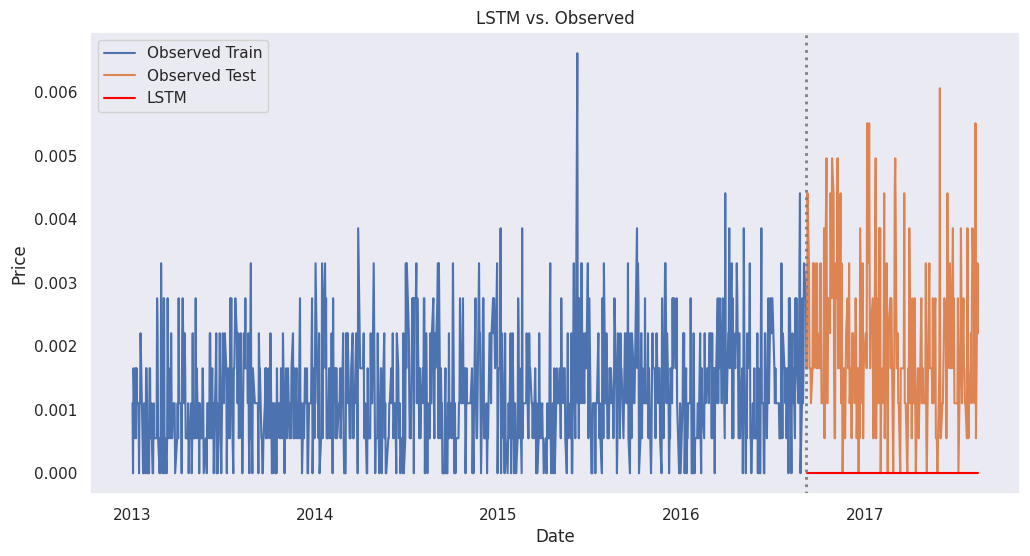

In [135]:
_ = test_forecast(forecast, categories[:N_families], store_nbrs[:N_stores])
plot_forecast(forecast, label="LSTM", family_idx=2, store_idx=0)

### 5 модель (LSTM для остатков Prophet)

#### Utils

In [148]:
df =  pd.concat([X_train, X_test])
df["sales"] = pd.concat([y_train, y_test]).values
df = df[df["family"].isin(categories[:N_families])
    & df["store_nbr"].isin(store_nbrs[:N_stores])]

In [149]:
prophet_forecast = prophet.forecast(X_train, X_test, return_train = True)

In [150]:
# Convert forecast dict to DataFrame
def replace_sales(df, prophet_forecast):
    df = df.copy()
    forecast_vals = np.concatenate(list(prophet_forecast.values()))
    df["forecast"] = forecast_vals[:len(df)]
    df["sales"] = df["sales"].values - df["forecast"].values
    df.rename(columns={"sales": "residuals"}, inplace=True)
    df.drop(columns=["forecast"], inplace=True)
    return df
df_resid = replace_sales(df, prophet_forecast)

In [151]:
df = df_resid

In [152]:
df.head()

,date,store_nbr,family,cluster,is_holiday,oil_price,year,day_of_year_sin,day_of_year_cos,day_of_month_sin,...,day_of_week_cos,month_sin,month_cos,encoding_store_nbr,encoding_family,encoding_year,lag_4,lag_8,lag_oil_14,residuals
0,2013-01-23,1,AUTOMOTIVE,13,0,0.815705,0,0.385663,0.922640,-0.998717,...,-0.222521,0.5,0.866025,0.070920,0.002902,0.058836,0.000551,0.001103,0.792965,0.000563
1,2013-01-24,1,AUTOMOTIVE,13,0,0.819140,0,0.401488,0.915864,-0.988468,...,-0.900969,0.5,0.866025,0.070920,0.002902,0.058836,0.000551,0.001654,0.790951,-0.001154
2,2013-01-25,1,AUTOMOTIVE,13,0,0.816771,0,0.417194,0.908818,-0.937752,...,-0.900969,0.5,0.866025,0.070489,0.002889,0.058768,0.000000,0.001103,0.792728,0.001587
3,2013-01-28,1,AUTOMOTIVE,13,0,0.826247,0,0.463550,0.886071,-0.571268,...,1.000000,0.5,0.866025,0.070839,0.002903,0.059030,0.000551,0.000551,0.793675,0.000445
4,2013-01-29,1,AUTOMOTIVE,13,0,0.846026,0,0.478734,0.877960,-0.394356,...,0.623490,0.5,0.866025,0.070489,0.002889,0.058768,0.001654,0.000551,0.793794,-0.000124


In [153]:
target_col = "residuals"
dynamic_num_cols = [x if x != "sales" else target_col for x in dynamic_num_cols]
X_dynamic, X_static, y = create_sequences(df, SEQUENCE_LENGTH, dynamic_cols=dynamic_num_cols, target_col=target_col)

  0%|          | 0/100 [00:00<?, ?it/s]

In [154]:
X_dynamic.shape, X_static.shape, y.shape

((117386, 4, 12), (117386, 2), (117386, 1))

In [155]:
(X_dynamic_train, X_dynamic_val, X_static_train, X_static_val, y_train, y_val) = (
    train_test_split(X_dynamic, X_static, y, test_size=0.2, random_state=42)
)
y_train_resid, y_test_resid, X_train_resid, X_test_resid = split_train_test(
    df, categories[:N_families], store_nbrs[:N_stores], target_col=target_col
)

In [156]:
X_dynamic_train.shape, X_static_train.shape, y_train.shape

((93908, 4, 12), (93908, 2), (93908, 1))

In [157]:
train_dataset = SalesDataset(X_dynamic_train, X_static_train, y_train)
val_dataset = SalesDataset(X_dynamic_val, X_static_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Model

In [159]:
model = SalesPredictorLSTM(
    num_dynamic_features=12,
    lstm_hidden_size=HIDDEN_SIZE_LSTM,
    fc_hidden_size=HIDDEN_SIZE_FC,
    num_static_features=2,
)
model.load_state_dict(torch.load("./lstm_resids.pth"))
model.to(DEVICE)
model.eval()

SalesPredictorLSTM(
  (static_mlp): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
  )
  (lstm): LSTM(12, 64, batch_first=True)
  (fc1): Linear(in_features=80, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [160]:
EPOCHS = 0
LEARNING_RATE = 5e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nStarting Training...")
for epoch in range(EPOCHS):
    model.train()
    train_loss_epoch = 0
    for dynamic_batch, static_batch, target_batch in tqdm(train_loader):
        dynamic_batch, static_batch, target_batch = (
            dynamic_batch.to(DEVICE),
            static_batch.to(DEVICE),
            target_batch.to(DEVICE),
        )

        optimizer.zero_grad()
        outputs = model(dynamic_batch, static_batch)
        loss = criterion(outputs, target_batch)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()
    train_loss_epoch /= len(train_loader)

    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for dynamic_batch, static_batch, target_batch in tqdm(val_loader):
            dynamic_batch, static_batch, target_batch = (
                dynamic_batch.to(DEVICE),
                static_batch.to(DEVICE),
                target_batch.to(DEVICE),
            )
            outputs = model(dynamic_batch, static_batch)
            loss = criterion(outputs, target_batch)
            val_loss_epoch += loss.item()
    val_loss_epoch /= len(val_loader)

    print(
        f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss_epoch:.6f}, Val Loss: {val_loss_epoch:.6f}"
    )



Starting Training...


In [161]:
X_forecast = X_train_resid[-len(y_train_resid):].copy()
X_forecast[target_col] = y_train_resid
X_forecast_test = X_test_resid.copy()
X_forecast_test[target_col] = 0.0
forecast = forecast_lstm(model, X_forecast, X_test_resid, target_col="residuals")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

In [162]:
added_forecast = {}
for (family, store_nbr) in forecast:
    added_forecast[(family, store_nbr)] = true_prophet_forecast[(family, store_nbr)].values + forecast[(family, store_nbr)].values.ravel()

Mean rmsle is 3.4867


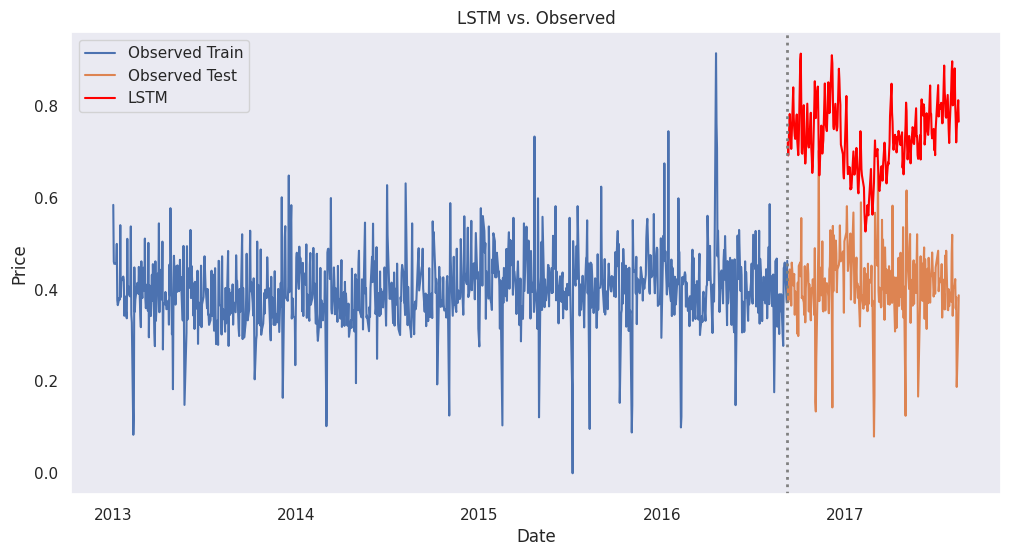

In [169]:
_ = test_forecast(added_forecast, categories[:N_families], store_nbrs[:N_stores], to_numpy=False)
plot_forecast(added_forecast, label="LSTM", family_idx=7, store_idx=0)

In [164]:
torch.save(model.state_dict(), './lstm_resids.pth')

### TSFen

In [ ]:
df_tsfen = train.copy()
df_tsfen = df_tsfen.loc[
    (df_tsfen["family"] == categories[0]) & (df_tsfen["store_nbr"] == store_nbrs[0])
]
df_tsfen

In [ ]:
import tsfel

cfg = tsfel.get_features_by_domain(["temporal", "statistical"])

# Extract features for 'sales'
features = tsfel.time_series_features_extractor(
    cfg, df["sales"].values, fs=1, window_size=12, overlap=11 / 12, verbose=1
)

features

In [ ]:
# Compute correlation matrix
corr_matrix = features.corr()

# Remove features with correlation > 0.9
features_filtered = tsfel.utils.signal_processing.correlated_features(
    features, threshold=0.9
)
features = features[features_filtered]
features.head()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

In [ ]:
X = features.copy()
X["sales"] = df["sales"].dropna()[:-11].values
X["sales_4"] = df["sales"].shift(4).dropna()[:-7].values
X["oil_11"] = df["oil_price"].shift(11).dropna().values
y = df.copy()
y["target"] = df["sales"].shift(-1).dropna()
y = y[:-11]

In [ ]:
def rmsle_objective(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.clip(preds, 0, None)
    grad = (np.log1p(preds) - np.log1p(labels)) / (preds + 1)
    hess = 1 / (preds + 1) ** 2
    return grad, hess


def rmsle_metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.clip(preds, 0, None)
    rmsle = np.sqrt(np.mean((np.log1p(labels) - np.log1p(preds)) ** 2))
    return "RMSLE", rmsle

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y["target"],
    test_size=0.2,
    shuffle=False,  # Critical for time series!
)

# Train model
model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    obj=rmsle_objective,
    feval=rmsle_metric,
    random_state=42,
)
model.fit(X_train, y_train)
# print("R² Score:", model.score(X_test, y_test))
prediction = model.predict(X_test)
root_mean_squared_log_error(prediction, y_test)

### 7 модель (GARCH)

In [ ]:
forecast = prophet.predict(future)[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
forecast.set_index("ds", inplace=True)
residuals = df["sales"] - forecast["yhat"][: len(df)]

In [ ]:
residuals.plot()

In [ ]:
from arch import arch_model

# Fit GARCH(1,1) model
model = arch_model(residuals, mean="Zero", vol="EGARCH", p=1, q=1)
results = model.fit(update_freq=5)  # Update frequency for output
print(results.summary())

In [ ]:
import matplotlib.pyplot as plt

# Plot conditional volatility
results.plot(annualize="D")  # Annualize daily volatility
plt.title("GARCH(1,1) Conditional Volatility")
plt.show()

In [ ]:
# Forecast volatility for the next 5 days
vol_forecasts = results.forecast(
    horizon=len(df_test), method="simulation"
).variance.iloc[-1]
std_dev = np.sqrt(vol_forecasts).values

mask = forecast.index > df.index.max()

forecast["yhat_lower_arch"] = np.nan
forecast["yhat_upper_arch"] = np.nan

# conf_level = 2.576 # 99%
# conf_level = 1.96 # 95%
# conf_level = 1.645 # 90%
conf_level = 1.28  # 80%

forecast.loc[mask, "yhat_lower_arch"] = (
    forecast.loc[mask, "yhat"].values - conf_level * std_dev
)
forecast.loc[mask, "yhat_upper_arch"] = (
    forecast.loc[mask, "yhat"].values + conf_level * std_dev
)

In [ ]:
# Plot observed vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Observed Train")
plt.plot(y_test_models.index, y_test_models["sales"], label="Observed Test")
plt.plot(forecast.index, forecast["yhat"], color="red", label="Forecast")
plt.fill_between(
    forecast.index,
    forecast["yhat_lower_arch"],
    forecast["yhat_upper_arch"],
    color="red",
    alpha=0.3,
    label="CI (garch)",
)

plt.fill_between(
    forecast.index,
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color="gray",
    alpha=0.3,
    label="CI (prophet)",
)


# Add vertical line to split train/forecast
plt.axvline(x=y_train.index[-1], color="gray", linestyle=":", linewidth=2)
plt.legend()
plt.title("Forecast vs. Observed")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.show()